![logo](../../picture/license_logo.png)
> **Copyright &copy; 2020 - 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# Univariate LSTM, Multi-Step Forecast

## Introduction
This tutorial is to demonstrate the process of building an LSTM model for Univariate Time Series Data for Multi Step. The flow of building the LSTM model is the same as in the Univariate Single Step, with an only difference being in the **Data Sequencing** part.<br> 

This notebook consists of 2 major parts which are:<br> 

Part 1 - The Demonstration of Building LSTM using Synthetic data.<br>
Part 2 - Exercise of building LSTM using shampoo sales data.<br> 

>**Instruction** : <br>
The instructor will code with you and guide you in the process of building the LSTM model using Synthetic data.<br>
You are required to complete the exercise after the demonstration.

## What will we accomplish?
First, we will show the steps in building the LSTM:<br> 

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Scaling and Batching the Data). <br> 
Step 2. Model Configuration (Vanila LSTM , Stacked LSTM , Bidirectional LSTM). <br> 
Step 3. Train the model. <br> 
Step 4. Validate the model using graph.  <br> 
Step 5. Evaluation Metrics such as MSE. <br> 
Step 6. Plot the forecast result.

Secondly, learn to use Python Dictionaries to make the code more manageable.

Let's import the package needed.

In [1]:
#import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
from matplotlib.lines import Line2D
from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import deep_learning_module
import data_module

# Part 1 : Demonstration of Building LSTM using Synthetic data

## Hyperparameter
Define the tuneable hyperparameters of the model.

In [2]:
split_ratio = 0.70
num_epochs = 60
window_size = 2
batch_size = 2
n_step = 2


# Step 1 : Data Preparation
We're creating a set of synthetic data to have something to work with and understand the process of creating a model better.<br>

1. We will create a sequence of data with `np.array`.
2. Then, we will assign a date to the sequence of data with `pd.date_range` and store it in a series format by using `pd.Series`.

In [3]:
# Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])
print(univariate_series.shape)
univariate_series

(40,)


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390])

In [4]:
univariate_series = pd.Series(univariate_series,pd.date_range("1/1/2020",
                                                             periods=len(univariate_series),
                                                            freq='D'))
univariate_series.head()

2020-01-01     0
2020-01-02    10
2020-01-03    20
2020-01-04    30
2020-01-05    40
Freq: D, dtype: int32

## Data Visualization
Data visualization is important for us to visualize the pattern of data such as trend and seasonality. As seen in the graph below, there is an increasing trend in the data.

>**Instruction** : <br>
Plot the graph using `univariate_series.plot` with the title `Synthetic Data"`

Text(0.5, 1.0, 'Synthetic Data')

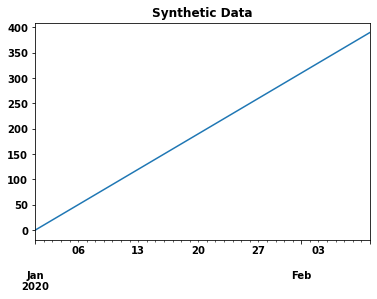

In [5]:
### BEGIN SOLUTION

univariate_series.plot()
plt.title("Synthetic Data")

### BEGIN SOLUTION

## Data Splitting
In Deep Learning, we will split the data into training and test dataset. The training data is used to train the model where the test data is used to validate the performance of the model.
>**Instruction** : <br>
Split the data by indexing. Remember to split the time index for later use. 

In [6]:
split_data = round(len(univariate_series)*split_ratio)
split_data

28

In [7]:
#split data by indexing 
train_data = univariate_series[:split_data]
test_data = univariate_series[split_data:]

train_time = univariate_series.index[:split_data]
test_time = univariate_series.index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


## Data Standardization
Standardize the data to have 0 mean and unit variance in order to make our model converge faster
>**Instruction** : <br>
Use `StandardScaler()` as the scaler for the data. Create scaled data using `scaler.transform` and store in respective `train_data_standard` and `test_data_standard`

In [8]:
# Build the standard scaler, Use to fit the train data and take the statistic of train data of train data to apply in test data.
scaler = StandardScaler().fit(train_data.values.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.values.reshape(-1, 1))
test_data_standard = scaler.transform(test_data.values.reshape(-1, 1))

In [9]:
print(f"train_data_standard shape : {train_data_standard.shape}")
print(f"test_data_standard shape : {test_data_standard.shape}")

train_data_standard shape : (28, 1)
test_data_standard shape : (12, 1)


## Data Sequencing
Sequencing the data by taking in the univariate series into `feature` and `label`
<img src = "../../picture/Data Sequencing in Univariate Multi-step.png"  width="300" height  ="300" align="center" />
>**Instruction** : <br>
You might need to use the sequencing function in `data_module` that will be able to perform the sliding window to create the multi-step univariate data.

In [10]:
### BEGIN SOLUTION
trainX ,trainY =  data_module.univariate_multi_step(train_data_standard,window_size,n_step)
testX , testY = data_module.univariate_multi_step(test_data_standard,window_size,n_step)
### END SOLUTION
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(25, 2, 1) trainY shape:(25, 2, 1)

testX shape:(9, 2, 1) testY shape:(9, 2, 1)


As you can see that the label data after sequence will have an additional dimension where the label dimension in [04 - LSTM_Univariate_SingleStep #Data Sequencing](./04%20-%20LSTM_Univariate_SingleStep.ipynb). : <br>
`trainY shape:(26, 1)`<br>
`testY shape: (10, 1)`<br>

Hence, we need to modify our training function in the `deep_learning_module` by adding an additional dimension in the training and the testing.<br>
`y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1],train_Y.shape[2]))`<br>
`y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1],test_Y.shape[2]))`<br>
>**Instruction** : <br>
Follow the instructor guidance to modify the `deep_learning_module`. 

After modifying the training function, we will create two dictionaries named `train_data_dictionary` , `test_data_dictionary` by creating a function name called  `key_assign`.These two dictionary will be applied in most of the following function..
>**Instruction** : <br>
Follow the instructor guidance to create the `key_assign` function.

In [11]:
def key_assign(trainingX,testingX,trainingY,testingY):
    """ 
    Use to assign  the key to create the train_data_dict and test_data_dict
    
    Arguments:
    trainingX -- feature for traning data 
    testingX -- feature for testing data
    trainingY -- label for traning data
    testingY -- label for testing data
    
    Returns: 
    train_data_dict -- dictionary of trainingX and trainingY
    test_data_dict -- dictionary of testingX and testingY
    """
    ### BEGIN SOLUTION
    
    # Create a dictionary that can store the train set feature and label
    train_data_dict = {"train_data_x_feature" : trainingX, "train_data_y_label" : trainingY}
    
    # Create a dictionary that can store the test set feature and label
    test_data_dict  = {"test_data_x_feature" : testingX , "test_data_y_label" : testingY }
    
    ### END SOLUTION
    return train_data_dict , test_data_dict

train_data_dictionary , test_data_dictionary = key_assign(trainingX = trainX,
                                 testingX = testX,
                                 trainingY = trainY,
                                 testingY = testY)


## Data Transform
Before we train the model, we need to transform our data from `ndarray` to `torch tensor`. It is almost the same process with the data transform in [04 - LSTM_Univariate_SingleStep #Data Transform](./04%20-%20LSTM_Univariate_SingleStep.ipynb)<br>
But this time we are trying to use the `train_data_dict` and `test_data_dict` to perform the data transform.
>**Instruction** : <br>
Follow the instructor guidance to create the `transform` function.

In [12]:
def transform(train_data_dict, test_data_dict):
    """ 
    Transform the NumPy data to torch tensor
    
    Arguments:
    train_data_dict -- train data dictionary 
    test_data_dict -- test data dictionary
    
    Returns: 
    train_data_dict -- train data dictionary 
    test_data_dict -- test data dictionary
    """
    ### BEGIN SOLUTION
    for train_datapoint in train_data_dict:
        train_data_dict[train_datapoint] =  torch.from_numpy(train_data_dict[train_datapoint]).type(torch.Tensor)
        
    for test_datapoint in test_data_dict:
        test_data_dict[test_datapoint] = torch.from_numpy(test_data_dict[test_datapoint]).type(torch.Tensor)
        
    ### END SOLUTION

    return train_data_dict,test_data_dict

train_data_dictionary,test_data_dictionary = transform(train_data_dictionary,test_data_dictionary)

Perform a sanity check of the shape to make sure the transform is correct
>**Instruction** : <br>
Follow the instructor guidance to create the `sanity_check` function

In [13]:
def sanity_check(data_1,data_2):
    """ 
    Print the shape of data_1 and data_2
    
    Arguments:
    data_1 -- (dict) type of data
    data_2 -- (dict) type of data 
    """
    
    ### BEGIN SOLUTION

    for key_1 in data_1:
        print(key_1 +" shape : " + str(data_1[key_1].shape))
    for key_2 in data_2:
        print(key_2 +" shape : " + str(data_2[key_2].shape))
        
    ### END SOLUTION

In [14]:
# Sanity check
sanity_check(train_data_dictionary,test_data_dictionary)

train_data_x_feature shape : torch.Size([25, 2, 1])
train_data_y_label shape : torch.Size([25, 2, 1])
test_data_x_feature shape : torch.Size([9, 2, 1])
test_data_y_label shape : torch.Size([9, 2, 1])


## Data Iterator
Iterator is created to separate the data into several batches to fasten the training process

1. First, we will use `TensorDataset` to "wrap" the feature and label together 
2. Then, use `DataLoader` to create the iterator base on the `batch_size`. 

>`shuffle = False` will be select since we don't want it to break the sequence information between each data<br>

This time, we'll  create a function by taking in the `train_data_dict`,`test_data_dict` as input to create the iterator
>**Instruction** : <br>
Follow the instructor guidance to create the `iterator` function


In [15]:
# Create Iterator
def iterator(train_data_dict,test_data_dict,batch_size):
    """ 
    Create iterator for train data and test data 
    
    Arguments:
    train_data_dict -- train data dictionary 
    test_data_dict -- test data dictionary
    
    Returns: 
    train_iter -- train data iterator 
    test_iter -- test data iterator 
    """
    ### BEGIN SOLUTION
    train_dataset = TensorDataset(train_data_dict["train_data_x_feature" ],
                                  train_data_dict["train_data_y_label"])
    train_iter = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

    test_dataset = TensorDataset(test_data_dict["test_data_x_feature"],
                                 test_data_dict["test_data_y_label"])
    test_iter = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    ### END SOLUTION
    
    return train_iter , test_iter

train_iter , test_iter = iterator(train_data_dictionary,test_data_dictionary,batch_size)

# Step 2 : LSTM Model Configuration 
Please refer to [04 - LSTM_Univariate_SingleStep # Step 2 : LSTM Model Configuration ](./04%20-%20LSTM_Univariate_SingleStep.ipynb) for the explanation

## Input Model

The model is initiated with the following required attributes: **number of input layer**, **output layer** and **hidden layer**.

How to Use :

1. Select one of the model base on the application as below and comment others model<br>
2. IF use Vanila LSTM , set num_layer = 1 and use the model = LSTM()<br>
3. IF use stacked LSTM , set num_layer more than 1 and use the model = LSTM()<br>
4. IF use Bidirectional LSTM, use the model = BidirectionalLSTM()<br>

>**Instruction** : <br>
Follow the instructor guidance to use the LSTM configuration from the `deep_learning_module`.


In [16]:
# seed
torch.manual_seed(123)

#Arguments for LSTM model
hidden_dim = 10
n_feature = 1 
n_step = 2

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1 

### BEGIN SOLUTION
#Vanila , Stacked LSTM
model = deep_learning_module.LSTM(n_feature = n_feature ,
                         hidden_dim = hidden_dim ,
                         num_layers = num_layers,
                         n_step = n_step)

#Bidirectional LSTM
# model = deep_learning_module.BidirectionalLSTM(n_feature = n_feature ,
#                          hidden_dim = hidden_dim ,
#                          num_layers = num_layers,
#                          n_step = n_step)
### END SOLUTION

Define the MSE as loss function and using Adam as the model optimizer

In [17]:
#loss function 
loss_fn = torch.nn.MSELoss()

#optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:
inputs = torch.zeros((batch_size,window_size,1),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model,inputs))

       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -   [2, 2, 10]     520        440
1_fc        [10, 2]       [2, 2]      22         20
---------------------------------------------------
                      Totals
Total params             542
Trainable params         542
Non-trainable params       0
Mult-Adds                460
       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -   [2, 2, 10]     520        440
1_fc        [10, 2]       [2, 2]      22         20


# Step 3 : Training
>**Instruction** : <br>
Follow the instructor guidance to use the `training` function from the `deep_learning_module`

In [19]:
# Start Training 
torch.manual_seed(123)
train_loss,val_loss = deep_learning_module.training(num_epochs,train_iter,test_iter,optimizer,loss_fn,model)

# Step 4 : Validation
A train loss and val loss is plotted to define how well the data is fitting the model

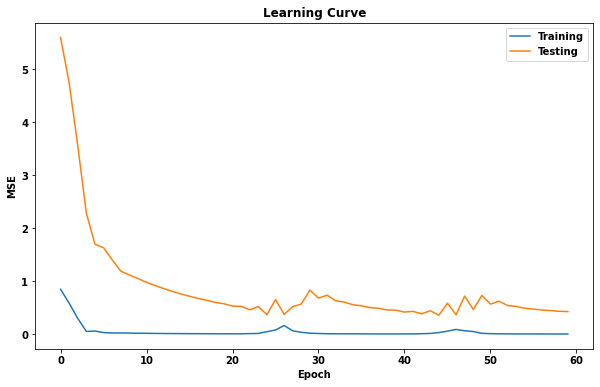

Epoch : 0 , training loss : 0.8443968538939953 , validation loss : 5.601115332709418
Epoch : 1 , training loss : 0.581803732663393 , validation loss : 4.743873861100939
Epoch : 2 , training loss : 0.2952052553743124 , validation loss : 3.5546370612250433
Epoch : 3 , training loss : 0.048428872178774326 , validation loss : 2.2803226047092013
Epoch : 4 , training loss : 0.056232127360999584 , validation loss : 1.6957567400402493
Epoch : 5 , training loss : 0.026377766523510218 , validation loss : 1.6291644308302138
Epoch : 6 , training loss : 0.019731516893953086 , validation loss : 1.402187877231174
Epoch : 7 , training loss : 0.019590658619999885 , validation loss : 1.1879600485165913
Epoch : 8 , training loss : 0.01713146744295955 , validation loss : 1.113423552778032
Epoch : 9 , training loss : 0.014501050040125847 , validation loss : 1.0493167638778687
Epoch : 10 , training loss : 0.012740965038537978 , validation loss : 0.9737101727061801
Epoch : 11 , training loss : 0.010865259869

In [20]:
data_module.learning_curve(num_epochs,train_loss,val_loss)

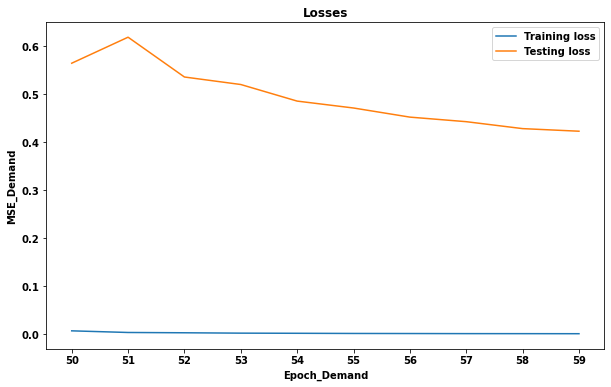

In [21]:
data_module.zoom_learning_curve(start_epoch = 50,
                                end_epoch =60 ,
                                training_loss = train_loss,
                                validation_loss = val_loss)

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data and determining the output forecast value and calculate the RMSE. For this tutorial, we will use the Python Dictionaries concept to create the function to run in each section.
>**Instruction** : <br>
Follow the instructor guidance to create the function for each section<br>

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data

In [22]:
# Section 1 : Feed in the train and test data to the model
with torch.no_grad():
    y_train_prediction = model(train_data_dictionary["train_data_x_feature"])
    y_test_prediction = model(test_data_dictionary["test_data_x_feature"])
    



We will create two new dictionary namely `prediction` and `output_data`.<br>
The `prediction` dictionary is to store the prediction of the model for both train data and test data .<br>
The `output_data` dictionary is to store the label data for both train data and test data.<br>
>**Instruction** : <br>
Follow the instructor guidance to create the `key_assign_evaluation` function


In [23]:
def key_assign_evaluation(y_train_prediction,
                          y_test_prediction,
                          train_data_dictionary,
                          test_data_dictionary):
    """ 
    Assign key for prediction and output data dictionary 
    
    Arguments:
    y_train_prediction -- (tensor) prediction for training data
    y_test_prediction -- (tensor) prediction for test data
    train_data_dictionary -- (dict) train data dictionary
    test_data_dictionary -- (dict) test data dictionary
    
    
    Returns: 
    prediction -- (dict) dictionary that consists of prediction from train data and test data
    output_data -- (dict) dictionary that consists of output(label) from train data and test data
    """
    ### BEGIN SOLUTION
    prediction ={"train_data_prediction" : y_train_prediction,
            "test_data_prediction" :y_test_prediction }
    output_data ={"train_data_output" : train_data_dictionary["train_data_y_label"] ,
               "test_data_output" : test_data_dictionary["test_data_y_label"]}
    ### END SOLUTION
    return prediction , output_data

prediction , output_data = key_assign_evaluation(y_train_prediction,y_test_prediction,
                                                 train_data_dictionary,
                                                 test_data_dictionary)     

In [24]:
# Check the prediction and output shape
sanity_check(data_1 = prediction,data_2 = output_data)

train_data_prediction shape : torch.Size([25, 2])
test_data_prediction shape : torch.Size([9, 2])
train_data_output shape : torch.Size([25, 2, 1])
test_data_output shape : torch.Size([9, 2, 1])


The train and test output data (label data) will have an extra dimension of 1 as shown as in the `sanity_check`<br>

`train_data_output shape : torch.Size([25, 2, 1])`<br>
`test_data_output shape : torch.Size([9, 2, 1])`<br>

Hence, we use `torch.squeeze` to eliminate the extra dimension of 1 to make sure it can be used to calculate the `RMSE` later.
>**Instruction** : <br>
Follow the instructor guidance to create the `squeeze_dimension` function.


In [1]:
# Section 2 : Reshape both to the original data dimension
def squeeze_dimension(output):
    """ 
    Squeeze the dimension of output data
    
    Arguments:
    output -- (dict) output_data
    
    Returns: 
    output_data -- (dict) output_data
    """
    ### BEGIN SOLUTION
    for key in output:
        output[key] = torch.squeeze(output[key],2)
    ### END SOLUTION
    return output

output_data = squeeze_dimension(output_data)

NameError: name 'output_data' is not defined

In [26]:
# Check the output shape
sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([25, 2])
test_data_output shape : torch.Size([9, 2])


>**Instruction** : <br>
Follow the instructor guidance to create the `inverse_scaler` function to scale back the scaled data to the original data value.


In [27]:
# Section 3 : Invert the scaling back to orignal data value
def inverse_scaler(scaled_data,scaler):
    """ 
    Inverse the scaled data
    
    Arguments:
    scaled_data -- (dict) data that being scaled 
    scaler -- scaler 
    
    Returns: 
    scaled_data -- (dict) data after inverse scale
    """
    ### BEGIN SOLUTION
    for item in scaled_data:
        scaled_data[item] =  scaler.inverse_transform(scaled_data[item].detach().numpy())
    ### END SOLUTION
    return scaled_data
    
prediction = inverse_scaler(prediction,scaler)
output_data  = inverse_scaler(output_data ,scaler)


In [28]:
sanity_check(data_1 = prediction,data_2 = output_data )

train_data_prediction shape : (25, 2)
test_data_prediction shape : (9, 2)
train_data_output shape : (25, 2)
test_data_output shape : (9, 2)



>**Instruction** : <br>
Follow the instructor guidance to create the `list_forecast_value` function to list the label (output) for test data and prediction side by side 


In [29]:
def list_forecast_value(output_data,prediction):
    """ 
    To list the test output and prediction output side by side
    
    Arguments:
    output_data --  (dict) output data dictionary
    prediction -- (dict) prediction output dictionary
    """
    ### BEGIN SOLUTION
    print("Test Data\t\t\tForecast")
    for test, forecast in zip(output_data["test_data_output"],prediction["test_data_prediction"]):   
        print(f"{test}\t\t{forecast}")
    ### END SOLUTION
        
list_forecast_value(output_data,prediction)        

Test Data			Forecast
[300. 310.]		[279.51312 290.955  ]
[310. 320.]		[283.2722  295.02792]
[320. 330.]		[286.44586 298.53497]
[330. 340.]		[289.10562 301.5451 ]
[340. 350.]		[291.31644 304.12073]
[350. 360.]		[293.13647 306.3172 ]
[360. 370.]		[294.61688 308.18304]
[370. 380.]		[295.80243 309.76035]
[380. 390.]		[296.73196 311.08557]


>**Instruction** : <br>
Follow the instructor guidance to create the `rmse` function to calculate the RMSE of train and test data


In [30]:
# Section 4 : Calculate the RMSE of train and test data
def rmse(prediction,output_data):
    """ 
    Calculate RMSE between output data and prediction data 
    
    Arguments:
    prediction -- (dict) prediction output dictionary
    output_data --  (dict) output data dictionary
    
    Returns:
    trainScore - RMSE of train dataset
    testScore - RMSE of test dataset
    """
    trainScore = math.sqrt(mean_squared_error(prediction["train_data_prediction"], output_data["train_data_output"]))
    testScore = math.sqrt(mean_squared_error(prediction["test_data_prediction"], output_data["test_data_output"]))
    return trainScore,testScore

trainScore,testScore = rmse(prediction,output_data)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.55 RMSE
Test Score: 52.53 RMSE


# Step 6 : Forecast Plot

>**How to plot a multi-step forecast?**<br>
>**Pipeline** : <br>
    1. First, we store the test data and forecast data in the form of `DataFrame` using `pd.DataFrame`.<br>
    2. Then, we slice the time index from the test time index base on the value in `window_size shampoo` to create new time index only for the data after the sliding window (data sequencing) <br>
    3. Create a for loop to plot the data sequence by sequence<br>

>**Optional function :**<br>
    1. Turn the `original_plot = True` to observe how sliding window (data sequence) take place in the test data<br>
    2. Assign `details = plot_details`  if you want to add details as such x-axis label , y-axis label,title<br>
    
>**Instruction** : <br>
Follow the instructor guidance to create the `multi_step_plot` function


In [31]:
plot_details ={"x-axis" : "Day",
          "y-axis" : "Values",
          "title"  : "Synthetic Data"
         }

In [32]:
# Plot forecast plot for multi-step
def multi_step_plot(original_test_data,
                    after_sequence_test_data ,
                    forecast_data,test_time,window_size,
                    n_step ,
                    details = {},
                    original_plot = False):
    
    """ 
    Plot the result of the multi-step forecast 
    
    Arguments:
    
    original_test_data -- test data before sequence
    
    after_sequence_test_data -- (dict) output data dictionary
    
    forecast_data -- (dict) prediction data dictionary
    
    test_time --  time index for test data before sliding window (data sequence)
    
    window_size -- window size for the data sequence
    
    n_step -- the number of future step , 1 -> single >1 -> multi-step
    
    details -- (dict) details for plot such as "x-axis" ,"y-axis", "title"
    
    original_plot -- (boolean) True ->observe how sliding window (data sequence) take place in the test data
    
    """
    
    after_sequence_test_data = after_sequence_test_data['test_data_output'] 
    forecast_data = forecast_data["test_data_prediction"]
    
    # Plot Setting
    plt.figure(figsize=(10,6))
    plt.xticks(rotation=45)    
    
    # Store test and forecast data into DataFrame type 
    column_names = ["timestep_" + str(i) for i in range(after_sequence_test_data.shape[1])]
    y_test_dataframe = pd.DataFrame(after_sequence_test_data,columns = column_names)
    y_test_pred_dataframe =pd.DataFrame(forecast_data,columns = column_names)
    
    # Create time index for data after sequence
    time_index_after_sequence = test_time[window_size:]
    
    # Test Data plot before sliding window(data sequencing)
    if original_plot:
        plt.plot(test_time,original_test_data,marker='x',color="blue")

    # For loop to plot the data step by step base on time index    
    start_idx = 0 
    for row in range(len(y_test_dataframe)):
        
        # Iterate the time index after sequence
        time_index = time_index_after_sequence[start_idx:start_idx+n_step]
        
        # Plot the test data
        plt.plot(time_index,y_test_dataframe.iloc[row],color="green",marker='o')
        
        # Plot the forecast data
        plt.plot(time_index,y_test_pred_dataframe.iloc[row],color="red",marker='o')
        
        # Pointer for time_index_after_sequence
        start_idx += 1
        
    # Customize the legend
    custom_lines = [Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="blue", lw=4)]
    plt.legend(custom_lines, ['Test Data After Sequencing', 'Forecast Data', 'Test Data Before Sequencing'])
    
    # Extra details - Optional function
    if details != {}:
        plt.xlabel(details["x-axis"])
        plt.ylabel(details["y-axis"])
        plt.title(details["title"])
    

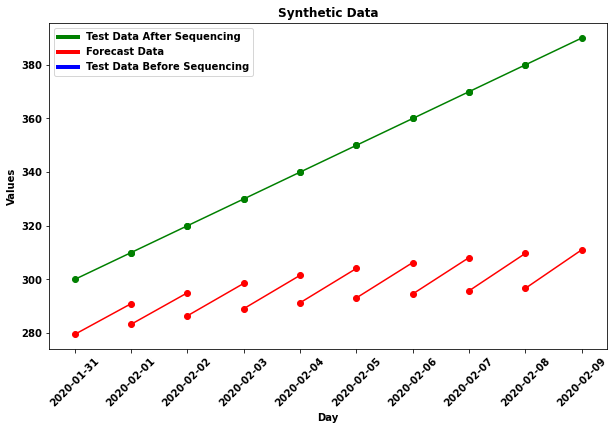

In [33]:
# Use the multi_step_plot function
multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = output_data ,
                forecast_data = prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = False)

***

# Part 2 : Exercise for Univariate 
## Task : To create an LSTM model that can predict sales of shampoo in multi-step

## Hyperparameter
>**Instruction** : <br>
You are required to fill `None` with a suitable value to make the model converge

>**Expected Result** : <br>
Train Score <= 60 RMSE<br>
Test Score <= 120 RMSE<br>

In [34]:
#Hyperparameter
num_epochs_shampoo = 100
split_ratio = 0.70
n_step_shampoo = 2
batch_size_shampoo = 2
window_size_shampoo = 2

#Hidden Layer for LSTM
hidden_dim_shampoo = 32



# Step 1 : Data Preparation
>**Instruction** : <br>
Read the file using `pd.read_csv`<br>
Your file path `../../datasets/others/shampoo-sales.csv`
Save your data as `shampoo`

>**Expected Result** : <br>
Example of the first 5 rows:

month| sales
---|---
0| 1-01|    266.0
1| 1-02|    145.9
2| 1-03|    183.1
3| 1-04|    119.3
4| 1-05|    180.3

In [35]:
# Read CSV file 

### BEGIN SOLUTION
shampoo = pd.read_csv('../../datasets/others/shampoo-sales.csv')
### END SOLUTION

shampoo.head() 

,month,sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


>**Instruction** : <br>
Set the `dataframe` index as `month` using `df.set_index`

>**Expected Result** <br>
Example of the first 5 rows:

month| month| sales
---|---|---
1-01| 1-01|    266.0
1-02| 1-02|    145.9
1-03| 1-03|    183.1
1-04| 1-04|    119.3
1-05| 1-05|    180.3

In [36]:
### BEGIN SOLUTION
shampoo_ts =  shampoo.set_index(shampoo['month'])  
### END SOLUTION

shampoo_ts.head() 

,month,sales
month,,
1-01,1-01,266.0
1-02,1-02,145.9
1-03,1-03,183.1
1-04,1-04,119.3
1-05,1-05,180.3


>**Instruction** : <br>
Save the data in `Series` form using `pd.Series`

>**Expected Result** : <br>
Example of the first 5 data

month|---
---|---
1-01|    266.0
1-02|    145.9
1-03|    183.1
1-04|    119.3
1-05|    180.3

In [37]:
### START SOLUTION
shampoo_ts = pd.Series(shampoo_ts['sales'])
### END SOLUTION
shampoo_ts.head()

month
1-01    266.0
1-02    145.9
1-03    183.1
1-04    119.3
1-05    180.3
Name: sales, dtype: float64

Text(0.5, 1.0, 'Time Series plot ')

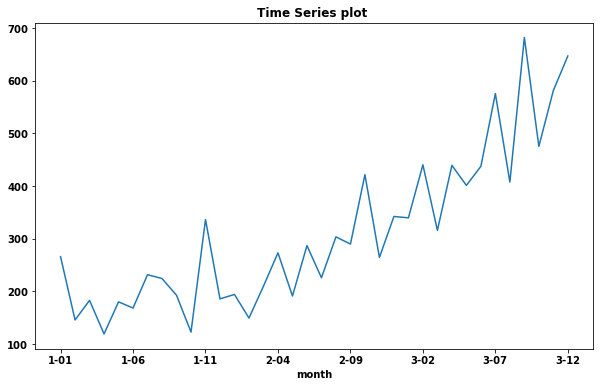

In [38]:
plt.figure(figsize=(10,6))
shampoo_ts.plot()
plt.title("Time Series plot ")

## Data Splitting
>**Instruction** : <br>
Split the data using indexing, your data should be splitted into `train_data_shampoo` and `test_data_shampoo`. Do remember to save the time index for train data and test data as well. Save the time index as `train_time_shampoo` and `test_time_shampoo`.

In [39]:
#split data by indexing 
split_data = round(len(shampoo_ts)*split_ratio)
split_data

25

In [40]:
# Visualize data shape after splitting
train_data_shampoo = shampoo_ts[:split_data]
test_data_shampoo = shampoo_ts[split_data:]
train_time_shampoo = shampoo_ts.index[:split_data]
test_time_shampoo = shampoo_ts.index[split_data:]
print("train_data_shampoo_shape")
print(train_data_shampoo.shape)
print("test_data_shampoo_shape")
print(test_data_shampoo.shape)

train_data_shampoo_shape
(25,)
test_data_shampoo_shape
(11,)


## Data Normalization
>**Instruction** : <br>
Use `MinMaxScaler()` to normalize the data, save your data scaler into `scaler_shampoo` and your train and test scaled data into `train_shampoo_scaled` and `test_shampoo_scaled`.<br>

Example :<br>
`train_shampoo_scaled = scaler_shampoo.transform(train_data_shampoo.values.reshape(-1,1))`

In [41]:
scaler_shampoo = MinMaxScaler().fit(train_data_shampoo.values.reshape(-1,1))
train_shampoo_scaled = scaler_shampoo.transform(train_data_shampoo.values.reshape(-1,1))
test_shampoo_scaled = scaler_shampoo.transform(test_data_shampoo.values.reshape(-1,1))

## Data Sequencing 
>**Instruction** : <br>
Use `univariate_multi_step` from the `data_module` to manipulate the scaled data into respective `x` and `y` variable.<br>

Example :<br>
`trainX_shampoo ,trainY_shampoo =  data_module.univariate_multi_step(train_shampoo_scaled,window_size_shampoo,n_step_shampoo)`

In [42]:
### BEGIN SOLUTION
trainX_shampoo ,trainY_shampoo =  data_module.univariate_multi_step(train_shampoo_scaled,window_size_shampoo,n_step_shampoo)
testX_shampoo , testY_shampoo = data_module.univariate_multi_step(test_shampoo_scaled,window_size_shampoo,n_step_shampoo)
### END SOLUTION

print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testY shape:{testY_shampoo.shape}")

trainX shape:(22, 2, 1) trainY shape:(22, 2, 1)

testX shape:(8, 2, 1) testY shape:(8, 2, 1)


## Data Transform
>**Instruction** : <br>
Assign your scaled data to dictionary by using `key_assign(trainingX,testingX,trainingY ,testingY)`.
Transform the data from `ndarray` to `torch tensor` using `transform(train_dict , test_dict)`<br>


In [43]:
### BEGIN SOLUTION
train_shampoo_dict , test_shampoo_dict = key_assign(trainingX = trainX_shampoo ,
           testingX = testX_shampoo,
           trainingY = trainY_shampoo ,
           testingY = testY_shampoo)

train_shampoo_dict , test_shampoo_dict = transform(train_shampoo_dict , test_shampoo_dict)
### END SOLUTION

In [44]:
sanity_check(train_shampoo_dict , test_shampoo_dict)

train_data_x_feature shape : torch.Size([22, 2, 1])
train_data_y_label shape : torch.Size([22, 2, 1])
test_data_x_feature shape : torch.Size([8, 2, 1])
test_data_y_label shape : torch.Size([8, 2, 1])


## Data Iterator
>**Instruction** : <br>
You are required to use the `iterator` function to create a data iterator that will enable the data to be stored in batches<br>


In [45]:
### BEGIN SOLUTION
train_iter_shampoo , test_iter_shampoo = iterator(train_shampoo_dict, test_shampoo_dict,batch_size_shampoo)
### END SOLUTION

## Input Model
>**Instruction** : <br>
You are required to input the correct model from `deep_learning_module`. Feel free to use any type of LSTM configuration. Please input the correct attributes and experiment with it. Save your model with the name `model_shampoo `<br>

In [46]:
#Arguments for LSTM model
# seed
torch.manual_seed(123)
### BEGIN SOLUTION
n_feature = 1 
#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers_shampoo = 1

#Vanila , Stacked LSTM
model_shampoo = deep_learning_module.LSTM(n_feature = n_feature ,
                         hidden_dim = hidden_dim_shampoo,
                         num_layers = num_layers_shampoo,
                         n_step = n_step_shampoo)

# Bidirectional LSTM
# model_shampoo = deep_learning_module.BidirectionalLSTM(n_feature = n_feature ,
#                          hidden_dim = hidden_dim_shampoo,
#                          num_layers = num_layers_shampoo,
#                          n_step = n_step_shampoo)
### END SOLUTION

>**Instruction** : <br>
Use `MSELoss` as the loss function and `Adam` as the optimizer. You are required to save `MSELoss` into a variable named `loss_fn_shampoo` and `Adam` optimizer into `optimizer_shampoo`<br>

In [47]:
### BEGIN SOLUTION
loss_fn_shampoo = torch.nn.MSELoss()

optimizer_shampoo = torch.optim.Adam(model_shampoo.parameters(), lr=0.01)

# Step 3 : Training
>**Instruction** : <br>
Input your training function from `deep_learning_module`<br>

In [48]:
# Start Training 
# seed
torch.manual_seed(123)

### BEGIN SOLUTION
train_loss_shampoo,val_loss_shampoo = deep_learning_module.training(num_epochs_shampoo,
                                                                    train_iter_shampoo,
                                                                    test_iter_shampoo,
                                                                    optimizer_shampoo,
                                                                    loss_fn_shampoo,
                                                                    model_shampoo)
### END SOLUTION

# Step 4 : Validation

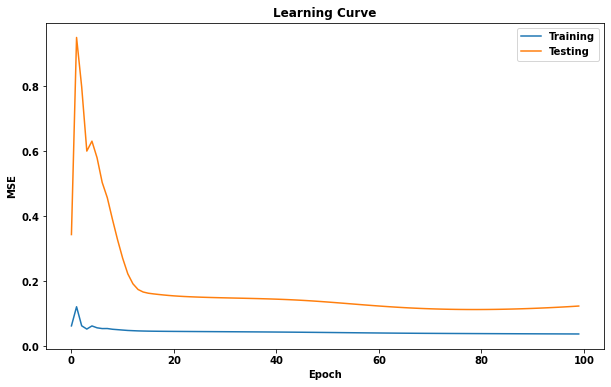

Epoch : 0 , training loss : 0.06233304061672904 , validation loss : 0.3433772660791874
Epoch : 1 , training loss : 0.12119243717329069 , validation loss : 0.9499602094292641
Epoch : 2 , training loss : 0.0625513784418052 , validation loss : 0.7977941706776619
Epoch : 3 , training loss : 0.052552273708649656 , validation loss : 0.6002853512763977
Epoch : 4 , training loss : 0.062171750447966835 , validation loss : 0.630828820168972
Epoch : 5 , training loss : 0.056392590261318466 , validation loss : 0.5797114595770836
Epoch : 6 , training loss : 0.05403260725804351 , validation loss : 0.5038881748914719
Epoch : 7 , training loss : 0.054175659717822615 , validation loss : 0.456723116338253
Epoch : 8 , training loss : 0.0519407222640108 , validation loss : 0.3904261291027069
Epoch : 9 , training loss : 0.050714796324345196 , validation loss : 0.32748950086534023
Epoch : 10 , training loss : 0.04945325597443364 , validation loss : 0.27041337080299854
Epoch : 11 , training loss : 0.04825303

In [49]:
# Plot Learning Curve 
data_module.learning_curve(num_epochs_shampoo,train_loss = train_loss_shampoo,
                           val_loss = val_loss_shampoo)

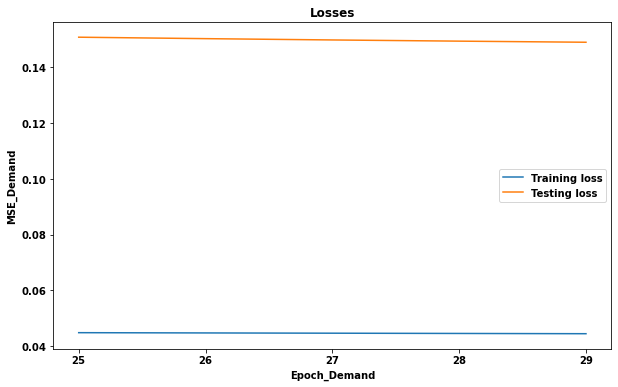

In [50]:
# Zoom in to visualize the graph by fill in start_epoch and end_epoch that want to analyse
data_module.zoom_learning_curve(start_epoch = 25,
                                end_epoch = 30,
                                training_loss = train_loss_shampoo,
                                validation_loss = val_loss_shampoo)

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data and using the forecasted value to calculate the RMSE. For this tutorial, we will use the Python Dictionaries concept to create the function to run in each section.
>**Instruction** : <br>
Use the function created in Part 1 to perform the task in each section.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data

In [51]:
# Section 1 : Make predictions
with torch.no_grad():
    y_train_prediction_shampoo= model_shampoo(train_shampoo_dict["train_data_x_feature"])
    y_test_prediction_shampoo= model_shampoo(test_shampoo_dict['test_data_x_feature'])



>**Instruction** : <br>
Use `key_assign_evaluation` to create the dictionary of `prediction_shampoo ` and `output_data_shampoo`

In [52]:
### BEGIN SOLUTION
prediction_shampoo , output_data_shampoo = key_assign_evaluation(y_train_prediction = y_train_prediction_shampoo ,
                                                 y_test_prediction = y_test_prediction_shampoo ,
                                                 train_data_dictionary = train_shampoo_dict,
                                                 test_data_dictionary =test_shampoo_dict) 
### END SOLUTION

>**Instruction** : <br>
Use `squeeze_dimension` to eliminate the extra dimension for `output_data_shampoo`

In [53]:
### BEGIN SOLUTION
output_data_shampoo = squeeze_dimension(output_data_shampoo)
### END SOLUTION

>**Instruction** : <br>
Use `inverse_scaler` to convert the scaled data back to original data. Your returned result must be in the dictionary form

In [54]:
### BEGIN SOLUTION
prediction_shampoo = inverse_scaler(prediction_shampoo ,scaler_shampoo)
output_data_shampoo = inverse_scaler(output_data_shampoo,scaler_shampoo)
### END SOLUTION

In [55]:
sanity_check(prediction_shampoo,output_data_shampoo)

train_data_prediction shape : (22, 2)
test_data_prediction shape : (8, 2)
train_data_output shape : (22, 2)
test_data_output shape : (8, 2)


In [56]:
list_forecast_value(output_data_shampoo,prediction_shampoo)

Test Data			Forecast
[439.3 401.3]		[393.23077 401.05264]
[401.3 437.4]		[346.09692 394.8552 ]
[437.4 575.5]		[425.88773 456.8816 ]
[575.5     407.59998]		[409.38068 445.68137]
[407.59998 682.     ]		[441.31796 452.8453 ]
[682.      475.29996]		[494.25705 517.15204]
[475.29996 581.3    ]		[424.3447  418.64893]
[581.3     646.89996]		[543.50165 551.7629 ]


In [57]:
trainScore_shampoo,testScore_shampoo = rmse(prediction_shampoo,output_data_shampoo)
print('Train Score: %.2f RMSE' % (trainScore_shampoo))
print('Test Score: %.2f RMSE' % (testScore_shampoo))

Train Score: 56.62 RMSE
Test Score: 106.19 RMSE


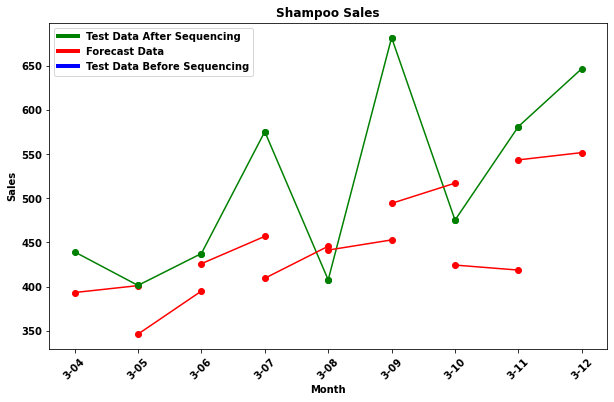

In [58]:
shampoo_details ={"x-axis" : "Month",
          "y-axis" : "Sales",
          "title"  : "Shampoo Sales"
         }
multi_step_plot(original_test_data = test_data_shampoo,
                after_sequence_test_data = output_data_shampoo ,
                forecast_data = prediction_shampoo,
                test_time = test_time_shampoo,
                window_size = window_size_shampoo ,
                n_step = n_step_shampoo,
                details = shampoo_details,
                original_plot = False)

## Summary
Through this tutorial you should have learned:

1. The pipeline of using LSTM perform univariate multi-step forecast 
2. Using Python Dictionaries make the code more manageable 
3. How to import function and class from Python module `data_module.py` and `deep_learning_module.py` 

Congratulations, that concludes this lesson.<br>

Please save the functions below to `data_module.py` .<br>

The following tutorial will utilise these function :<br>
`key_assign` <br>
`key_assign_evaluation`<br>
`transform`<br>
`sanity_check`<br>
`iterator`<br>
`squeeze_dimension`<br>
`inverse_scaler`<br>
`list_forecast_value`<br>
`rmse`<br>
`multi_step_plot`<br>



Please proceed to other notebook for other type of data in LSTM forecasting  <br>
1. ~~*[04 - LSTM_Univariate_SingleStep]*~~  *Complete*
2. ~~*[04 - LSTM_Univariate_MultiStep.ipynb]*~~ *Complete*
3. [04 - LSTM_Multivariate_Univariate_SingleStep](./04%20-%20LSTM_Multivariate_Univariate_SingleStep.ipynb)<br>
4. [04 - LSTM_Multivariate_Univariate_MultiStep](./04%20-%20LSTM_Multivariate_Univariate_MultiStep.ipynb)<br>

## Reference
1. [Multistep Time Series Forecasting with LSTMs in Python](https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/)
2. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)